In [13]:
#!pip install matplotlib


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:181: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(72, 4090.0, 10717)


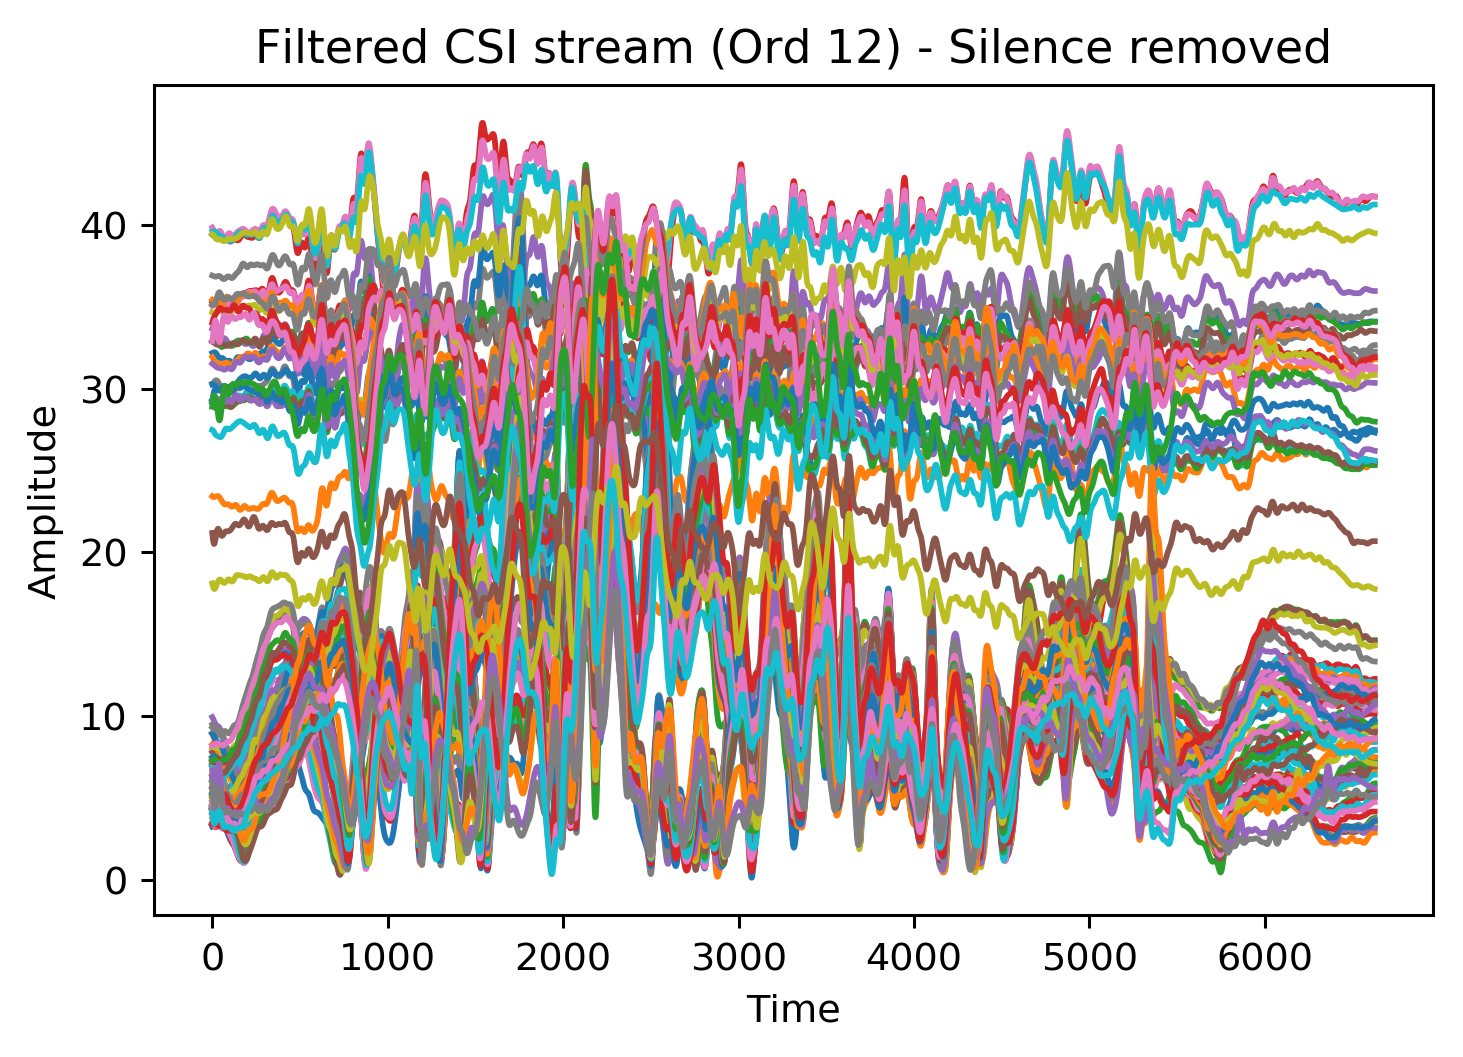

In [14]:

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, medfilt

matlab_file = './Sushant_CSI/1m/backward_converted/log_2.mat'
plt.rcParams['figure.dpi'] = 275

H = [] # this shit will contain the dataset of trimmed data.
original = []
trimmed_lengths = []
start_end = []

# Load matlab file containing Amplitude domain CSI data
for subcarrier in range(90):

    mat_contents = sio.loadmat(matlab_file)
    antenna = mat_contents['M']
    #subcarrier = 89   # Selected Subcarrier
    fs = 0.05        # Sampling Frequency
    flt_ord = 12     # Filter order number

    # Create list of CSI stream of one subcarrier
    x_axis = []
    y_axis = []
    for i in range(0, len(antenna)):
        x_axis.append(i)
        y_axis.append(antenna[i][subcarrier])

    # plt.plot(y_axis)
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Amplitude')
    # plt.title('Raw CSI stream')

    flt_ord = 12
    b, a = butter(flt_ord, 0.05, 'lowpass', analog=False)
    output = filtfilt(b, a, y_axis)
    original.append(output)

    # plt.plot(output)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Filtered CSI stream (Ord 12)')

    # flt_ord = 5
    # b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
    # output = filtfilt(b, a, y_axis)
    # plt.plot(output)
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Filtered CSI stream (Ord 5)')

    # -- SILENCE REMOVAL ---
    import math

    # Separate the CSI data into a sequence of frames
    num_packets = len(output)

    # 50 ms is the number of data(frequency) in each frame.

    data_per_frame = 50
    total_num_frames = math.floor(num_packets/data_per_frame) 

    frames = []
    for frame in range(int(total_num_frames)):
        cur_index = data_per_frame*frame
        seq = output[cur_index : cur_index+data_per_frame]
        frames.append(seq)


    # Calculate energy for each frame
    # Energy each frame = Average of the Squares for each frame
    energy = []
    for frame in frames:
        sq_sum = sum(map(lambda x: x*x, frame))
        e_frame = sq_sum/data_per_frame
        energy.append(e_frame)

    # Apply median filter to energy values and take their log
    filt_energy = medfilt(energy)
    filt_energy = [math.log(e) for e in filt_energy]

    # Select contiguous block of frames s_mid for which energy > mean energy

    # Get indices for which energy > mean energy
    curr_index = 0
    high_energy_indices = []
    mean_energy = sum(filt_energy)/len(filt_energy)
    for energy in filt_energy:
        if energy > mean_energy:
            high_energy_indices.append(curr_index)
        curr_index += 1;

    # Split the high energy indices into contigious subsequences
    curr_index = None
    inside_arr = []
    conti_arr = []
    for index in high_energy_indices:
        if (curr_index is None):
            inside_arr.append(index)
        else:
            if (curr_index == index-1):
                inside_arr.append(index)
            else:
                conti_arr.append(inside_arr)
                inside_arr = []
                inside_arr.append(index)

        curr_index = index

    if inside_arr:
        conti_arr.append(inside_arr)

    # Select the longest contigious subsequence
    s_mid = max(conti_arr, key=len)

    # Get the corresponding CSI data frames h_mid for s_mid
    h_mid = []
    for index in s_mid:
        h_mid.append(frames[index])


    # Calculate the midpoint of the region h_mid which has maximum
    # deviations from the average in h_mid

    high_energy_csi = [item for sublist in h_mid for item in sublist]
    avg_energy = sum(high_energy_csi)/len(high_energy_csi)

    max_dev = 0
    max_dev_index = 0
    for index, energy in enumerate(high_energy_csi):
        deviation = abs(avg_energy - energy)
        if deviation > max_dev:
            max_dev = deviation
            max_dev_index = index

    m = s_mid[0] * data_per_frame + max_dev_index 

    # Set start_point to m−T/2, where T is total duration
    start_point = math.floor(m - (num_packets)/2)
    start_point = max(start_point, 0)

    # Set end_point to m+T/2, where T is total duration
    end_point = math.floor(m + (num_packets)/2)
    end_point = min(end_point, num_packets)

    #Before Silence removal
#     plt.plot(output)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12)')

    # Trimmed output is the CSI stream after silence has been removed.

#     trimmed_output = np.full(num_packets, np.nan)
#     trimmed_output[start_point:end_point] = output[start_point:end_point]
    trimmed_output = output[start_point:end_point]
#     print(trimmed_output
#     plt.plot(trimmed_output)
#     plt.xlim(left=0, right=num_packets)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12) - Silence removed')

    #print(trimmed_output)
    # ------------------------- IDK if this is correct ---------------------------
    # Finally adding all of the trimmed shit as H ?????

    H.append(trimmed_output)
    trimmed_lengths.append(len(trimmed_output))
    start_end.append((start_point, end_point))
    
best_subcarrier = trimmed_lengths.index(min(trimmed_lengths))
(best_start, best_end) = start_end[best_subcarrier]

silenced_data = [] # Contains the original csi data for which each subcarrier is trimmed from best_start to best_end
for untrimmed in original:
    new_csi = untrimmed[best_start:best_end]
    silenced_data.append(new_csi)
    
print(best_subcarrier, best_start, best_end)
# plt.plot(H[best_subcarrier])

# plt.xlim(left=best_start, right=best_end)


for silenced in silenced_data:
    plt.plot(silenced)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Filtered CSI stream (Ord 12) - Silence removed')

# ----------------------------------------- NOW H has all the trimmed data. -------------------

# fs = 500    # The sampling rate
# nfft = 50   # Length of windowing segments
# plt.specgram(output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True)#, xextent=(0,1.627))
# plt.margins(x=0, y=1)

# plt.specgram(trimmed_output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True,)# xextent=(0,1.627))


In [15]:
# for untrimmed in original:
#     plt.plot(untrimmed)
#     plt.xlim(left=0, right=num_packets)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.title('Filtered CSI stream (Ord 12) - Silence removed') 

# SIGNAL SEPARATION
# Now start Signal separation
# import mlpy

# x = H[0]
# coef, freqs=pywt.cwt(x,np.arange(1,10),'morl')
# plt.plot(coef)
# plt.specgram(freqs, Fs=10, cmap='jet', NFFT=5, noverlap=4, scale_by_freq=True,)# xextent=(0,1.627))

# plt.matshow(coef)
# plt.show() 

# dt = 1
# # scales = [6,7,8,9]
# # print(H[0])
# # # n = int()
# scales = mlpy.wavelet.autoscales(N=H[0].shape[0], dt=dt, dj=0.1, wf='morlet', p=2)
# # print(scales.shape)
# # print(type(scales))
# # new_scales = scales.view(-1)
# # print(new_scales)
# X = mlpy.wavelet.cwt(H[0], dt, scales, wf='morlet', p=2)
# print(scales)
# # print(X)

# # fig = plt.figure(1)
# # ax1 = plt.subplot(2,1,1)
# # p1 = ax1.plot(H[0])
# # ax1.autoscale_view(tight=True)
# # ax2 = plt.subplot(2,1,2)
# # p2 = ax2.imshow(np.abs(X), interpolation='nearest')
# # plt.show()


# #print(np.abs(X))
# plt.imshow(np.abs(X))
# # plt.xlim(left=3500, right=4000)





In [16]:
from scipy.stats import kurtosis, skew
#from skrebate import ReliefF
#from sklearn.pipeline import make_pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score


# Feature extraction shit here.
num_packets = len(H[0])
data_per_window = 100
total_num_windows = math.floor(num_packets/data_per_window) 

# Split data into windows of 100 packets / 0.1 seconds
windows = []
for window in range(int(total_num_windows)):
    cur_index = data_per_window*window
    seq = H[0][cur_index : cur_index+data_per_window]
    
    windows.append(seq)

#print(windows)

features = []

def getZeroCrossingRate(arr):
        my_array = np.array(arr)
        #print(my_array)
        return float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr)))
    
def getMeanCrossingRate(arr):
    #print(arr)
    return getZeroCrossingRate(np.array(arr) - np.mean(arr))

# For each window, gather its features
for each_window in windows:
    # time domain features
    
    weight_each_window = []
    
    mean = sum(each_window) / len(each_window)
    max_val = max(each_window)
    min_val = min(each_window)
    skewness = skew(each_window)
    kurtosis_val = kurtosis(each_window)
    variance = np.var(each_window)
    
    # !!! MEAN crossing rate shit doesnt work !!!
    mean_crossing_rate = getMeanCrossingRate(each_window)
    
    weight_each_window.append(mean)
    weight_each_window.append(max_val)
    weight_each_window.append(min_val)
    weight_each_window.append(skewness)
    weight_each_window.append(kurtosis_val)
    weight_each_window.append(variance)
    weight_each_window.append(mean_crossing_rate)
    
    features.append(weight_each_window)
    
# # print(mean)
# # print(max_val)
# # print(min_val)
# # print(skewness)
# # print(kurtosis_val)
# # print(variance)
# # print(mean_crossing_rate)

# # print(features)
# label_len = len(features)
# labels = np.zeros(label_len)

# print(labels)
# clf = make_pipeline(ReliefF(n_features_to_select=2, n_neighbors=100),
#                     RandomForestClassifier(n_estimators=100))


# print(clf)
# print(np.mean(cross_val_score(clf, features, labels)))



In [17]:

# Doing the classifying using features above

